# Check training

### controlla i training già finiti e aggiunge alla lista nuovi task che arrivano da una chiamata a diz_trials

In [1]:
from pathlib import Path
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import json_normalize
import yaml
import pickle

from Metrics import Metrics

from utils_embednet import array_wo_outliers

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('display.width', 2000)
from IPython.display import display, HTML

custom_styling = [
        {
            "selector": "th",
            "props": [
                ("background", "#00abe7"),
                ("color", "white"),
                ("font-family", "tahoma"),
                ("text-align", "center"),
                ("font-size", "15px"),
            ],
        },
        {
            "selector": "td",
            "props": [
                
                ("font-family", "tahoma"),
                ("color", "black"),
                ("text-align", "left"),
                ("font-size", "15px"),
            ],
        },
        {
            "selector": "tr:nth-of-type(odd)",
            "props": [
                ("background", "white"),
            ],
        },
        {"selector": "tr:nth-of-type(even)", "props": [("background", "#e8e6e6")]},
        {"selector": "tr:hover", "props": [("background-color", "#bfeaf9")]},
        {"selector": "td:hover", "props": [("background-color", "#7fd5f3")]},
    ]

folder = Path("/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8")
root_task = Path("/home/daniele/Documenti/Progetti/Networks/Embednet/head_train_tasks")
all_runs_csv = root_task / "head_run_tasks.csv"

### Bootstrap the dataframe: un df che contiene solo i path di tutti i config.yml di tutte le sottocartelle di training

In [2]:
def give_configs(folder):
    """data una cartella di root prende tutte le sottocartelle e cerca 
    i file config.yml per aggiungerli a una lista che conterrà tutit i nomifile di ogni cartella
    """
    file_list = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.endswith(".yml"):
                #file_list.append(os.path.join(root, f))               
                file_list.append(root)
    return file_list


In [5]:
file_list = give_configs(folder)
head_df = pd.DataFrame(data=file_list, columns=["folders"])
head_df

,folders
0,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX20___#__AE_CM______§1-128-8§_______ELU+RELU__grphnorm__-xavier_normal___#__lr0010003999999999999_ADAMW_BCELoss
1,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi300_grafiX20___#__AE_CM______§1-16-2§________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00005012_ADAMW_BCELoss
2,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX30___#__AE_CM______§1-32-8§________ELU+RELU__grphnorm__-xavier_normal___#__lr0010003_ADAMW_BCELoss
3,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi30__grafiX30___#__AE_CM______§1-32-16§_______ELU+RELU__grphnorm__-eye________#__lr00007_ADAMW_BCELoss
4,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-05]_Classi-1_nodi800_grafiX40___#__AE_CM______§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
...,...
977,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX100__#__AE_CM______§1-16-2§________ELU+RELU__grphnorm__-xavier_normal___#__lr00005007_ADAMW_BCELoss
978,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi300_grafiX100__#__AE_CM______§1-16-2§________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00005012_ADAMW_BCELoss
979,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[025]_Classi-1_nodi20__grafiX50___#__AE_fullMLP_CM_§128-128§_______ELU+RELU__grphnorm__-___________#__lr000025_ADAMW_BCELoss
980,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX20___#__AE_CM______§1-64-16-8§_____ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00020007000000000002_ADAMW_BCELoss


In [6]:
head_df.to_csv(all_runs_csv, index=False)

In [7]:
# load the df
head_df = pd.read_csv(all_runs_csv)
head_df

,folders
0,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX20___#__AE_CM______§1-128-8§_______ELU+RELU__grphnorm__-xavier_normal___#__lr0010003999999999999_ADAMW_BCELoss
1,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[09]_Classi-1_nodi300_grafiX20___#__AE_CM______§1-16-2§________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00005012_ADAMW_BCELoss
2,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX30___#__AE_CM______§1-32-8§________ELU+RELU__grphnorm__-xavier_normal___#__lr0010003_ADAMW_BCELoss
3,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi30__grafiX30___#__AE_CM______§1-32-16§_______ELU+RELU__grphnorm__-eye________#__lr00007_ADAMW_BCELoss
4,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-05]_Classi-1_nodi800_grafiX40___#__AE_CM______§1-8-4§_________ELU+RELU__grphnorm__-xavier_normal___#__lr00001_ADAMW_BCELoss
...,...
977,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX100__#__AE_CM______§1-16-2§________ELU+RELU__grphnorm__-xavier_normal___#__lr00005007_ADAMW_BCELoss
978,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[07]_Classi-1_nodi300_grafiX100__#__AE_CM______§1-16-2§________ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00005012_ADAMW_BCELoss
979,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[025]_Classi-1_nodi20__grafiX50___#__AE_fullMLP_CM_§128-128§_______ELU+RELU__grphnorm__-___________#__lr000025_ADAMW_BCELoss
980,/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__[01]_Classi-1_nodi300_grafiX20___#__AE_CM______§1-64-16-8§_____ELU+RELU__grphnorm__-xavier_normal__UNnorm_adj_#__lr00020007000000000002_ADAMW_BCELoss


In [ ]:
s1 = head_df.style
s1.set_table_styles(custom_styling)
s1.hide(axis="index")
# NOTE: Adding div Style with overflow!
display(HTML("<div style='width: 5090px; overflow: auto;'>" +
             s1.to_html() +
             "</div>"))

In [115]:
str(Path(head_df.iloc[0].values[0]).parent)

'/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__Classi-1_nodi100_grafiX100__#__AE_CM__§32-32-32§__ELU+RELU__grphnorm__-xavier_normal_#__lr0001_ADAM_BCELoss'

### Ora procedo con le funzioni che serviranno per aggiornare questo df

In [4]:
def add_row(df_file, row_content):
    with open(df_file, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([row_content])
        
def add_many_rows(df_file, rows):
    with open(df_file, 'a') as f:
        writer = csv.writer(f)
        for r in rows:
            writer.writerow([r])
    

#### Aggiungere tutte le nuove cartelle insieme, nel caso in cui il watchdog non era attivo mentre venivano create nuove cartelle

In [29]:
file_list = give_configs(folder)
print(f"In tutto ci sono {len(file_list )} files")
total_files = pd.DataFrame(file_list, columns=["folders"])
to_add = total_files[~total_files['folders'].isin(head_df['folders'])]

In tutto ci sono 311 files


In [33]:
add_many_rows(all_runs_csv, to_add.folders)

### Watchdog

In [31]:
import sys
import time
import logging
from watchdog.observers import Observer
from watchdog.events import LoggingEventHandler
from watchdog.events import FileSystemEventHandler

In [62]:
def watch_new_configs(filder):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')
    event_handler = LoggingEventHandler()
    observer = Observer()
    observer.schedule(event_handler, folder, recursive=True)
    observer.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

In [139]:
    
class MyHandler(FileSystemEventHandler):
    #def on_any_event(self, event):
    #    print(event.event_type, event.src_path)

    def on_created(self, event):
        #print("on_created", event.src_path)
        #print(event.src_path.strip())
        if "§training_ended§" in event.src_path.strip():        
            #print("Execute your logic here!")            
            path = Path(event.src_path.strip()).parent
            add_row(all_runs_csv, path)
            print(f"salvato il path: {path}?")

In [140]:
event_handler = MyHandler()
observer = Observer()
observer.schedule(event_handler, path=folder, recursive=True)
observer.start()

salvato il path: /home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-22]_Classi-1_nodi150_grafiX50___#__AE_CM______§1-8-4-2§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00005_ADAMW_BCELoss?


In [169]:
observer.stop()

### ora la parte che prende da tutti i config trovati le metriche, e le aggiunge a un df dei run totali

In [7]:
def build_results_df_from_configs(df_input):
    list_dfs = []
    for row in df_input.iterrows():
        #leggo un config per volta: ho un df da una riga, che poi concateno in un unico df
        root = Path(row[1].values[0] )
        conf = yaml.safe_load(open(root / "config.yml"))
        df = json_normalize(conf)
        df = df.astype('object')

        # aggiungo i risultati al df della config, sempre fatto di una sola riga
        for m in list_metriche_loss_dims:
            col = f"risultati.{m}"
            file = root / (m +".pkl")
            if file.is_file():
                with open(file, 'rb') as f:
                    list_values = pickle.load(f) 
                    #print(list_values)
                    if isinstance(list_values[0], Metrics):
                        for name in metric_names:
                            metrica_values = [m.get_metric(name) for m in list_values]
                            col = f"risultati.{m}_{name}" 
                            df.at[0, col] ='s' # forza un cast a object
                            df.at[0, col] = tuple(metrica_values)
                            #display(df[[col]])
                    else:
                        df.at[0, col] ='s' # forza un cast a object
                        df.at[0, col] = tuple(list_values) # è meglio che i tipi delle colonne non sano mai liste


        df.columns = df.columns.str.split('.', expand=True)
        list_dfs.append(df)
    
    final_df = pd.concat(list_dfs, axis=0) 
    # Filtrare il DataFrame per rimuovere le righe con NaN in 'risultati','train_loss'
    # perché tanto la train loss la metto sempre, se manca vuol dire che manca tutto il resto
    filtered_df = final_df.dropna(subset=[('risultati', 'train_loss')])

    return filtered_df

In [8]:
#root_task / "head_run_tasks.csv"
list_metriche_loss_dims = [
"metrics_train",
"metrics_test",
"totale_node_dim",
"totale_graph_dim",
 "train_loss",
"test_loss"]
metric_names = ["pr_auc", "euclid"]

final_df = build_results_df_from_configs(head_df)
    


In [27]:
def make_plot_data(losses, feature):
    plot_data = []
    # for arch, loss in zip(architecture_values, loss_values):
    for f, loss in zip(feature, losses):
        num_layers = len(f)
        total_neurons = sum(f) 
        epoche = range(len(loss))
        #print(len(epoche), len(loss))
        #loss_list_min, loss_list_max = min(array_wo_outliers(loss)), max(array_wo_outliers(loss))
        #print(loss_list_min, loss_list_max)
        plot_data.append({
            'x': epoche,
            # 'arch': arch,
            'feat': f,
            'loss': loss,
            'num_layers': num_layers,
            'total_neurons': total_neurons,
            'label': f'Layers: {num_layers}, Neurons: {total_neurons}',
            #'label': f'Num grafi: {f}',
            #'min': loss_list_min,
            #'max': loss_list_max
        })
    return plot_data

In [12]:
loss_values = final_df[('risultati', 'train_loss')]
test_losses = final_df[('risultati', 'test_loss')]
architecture_values = final_df[('model', 'GCNneurons_per_layer')]
dataset_grafi = final_df[('graph_dataset', 'Num_grafi_per_tipo')]
dataset_nodi = final_df[('graph_dataset', 'Num_nodes')]

plot_data_grafi = make_plot_data(test_losses, dataset_grafi)

In [28]:
node_emb_dim = final_df[('risultati', 'totale_node_dim')]
architecture_values = final_df[('model', 'GCNneurons_per_layer')]
plot_data_grafi = make_plot_data(node_emb_dim, architecture_values)

In [37]:
len(plot_data_grafi)

537

In [57]:
def plot_curves_vs_features(plot_data, titolo=None, titolo_laterale=None):    
    # Utilizzo della colormap 'tab10' che offre colori ben distinti
    # Altre opzioni possono essere 'viridis', 'plasma', 'inferno', 'magma', 'cividis', "tab10"
    cm = plt.get_cmap('plasma') 
    num_colors = len(plot_data)
    colors = [cm(1.*i/num_colors) for i in range(num_colors)]


    # Ordinamento basato su numero di layer e numero totale di neuroni
    #plot_data.sort(key=lambda x: (int(x['label'].split(',')[0].split(': ')[1]), int(x['label'].split(',')[1].split(': ')[1])))

    # ordinamento basato sul numero di grafi nel dataset
    plot_data.sort(key=lambda x: x['total_neurons'])

    # Creazione del grafico
    plt.figure(figsize=(10, 6))
    for i, data in enumerate(plot_data):
        plt.plot(data['x'], data['loss'], label=data['label'], color=colors[i], linestyle='None', marker='.')

    # Aggiungere una colorbar
    #min_nodi, max_nodi = min(dataset_grafi), max(dataset_grafi)
    total_neurons = [p['total_neurons'] for p in plot_data]
    min_f, max_f = min(total_neurons), max(total_neurons)
    sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min_f, vmax=max_f))
    plt.colorbar(sm, label=titolo_laterale)

    plt.ylim(0.0, 5.0)

    plt.title('Loss per Epoca')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.legend()  #
    plt.xscale('log')
    if titolo:
        plt.savefig(titolo)
    plt.show()

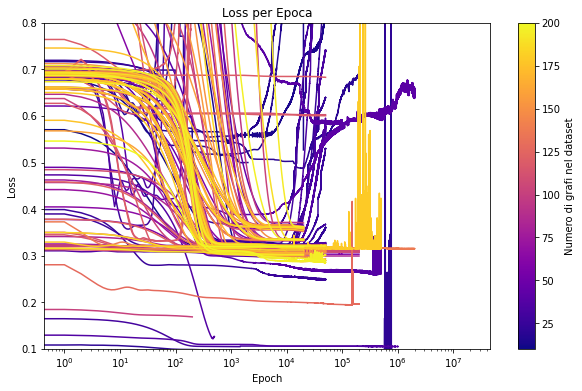

In [15]:
plot_curves_vs_features(plot_data_grafi, titolo='Test_loss_vs_num_grafi', titolo_laterale='Numero di grafi nel dataset')

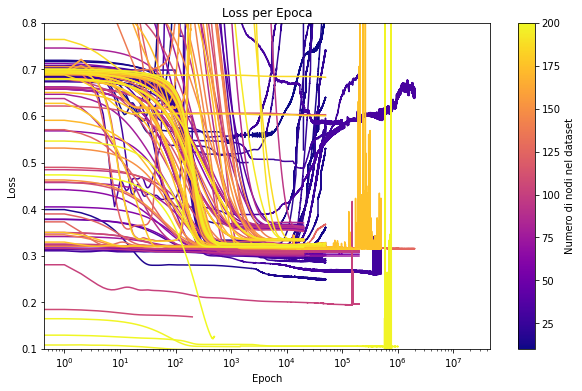

In [18]:
plot_curves_vs_features(make_plot_data(test_losses, dataset_nodi), titolo='Test_loss_vs_num_nodi', titolo_laterale='Numero di nodi nel dataset')

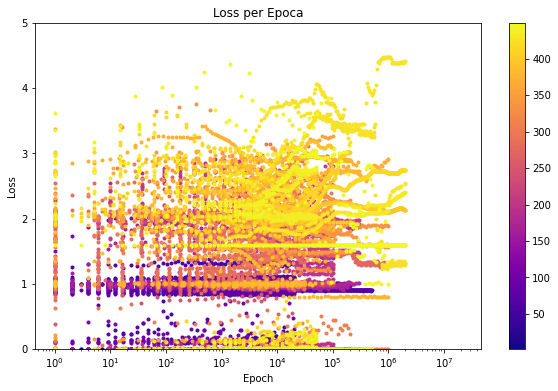

In [58]:
plot_curves_vs_features(plot_data_grafi)